In [5]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/Rn222Study


In [2]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os
import time

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

import importlib

importlib.reload( nEXOFitWorkspace )

<module 'nEXOFitWorkspace' from '../../../modules/nEXOFitWorkspace.py'>

# Define useful functions

In [72]:
def ExtractParameterFitValuesToDict(pull_df, parameter_efficiencies):
    variable_names_list = list(pull_df['best_fit_parameters'].iloc[0].keys())
    
    parameter_fit_dict = {}
    parameter_input_dict = {}
    parameter_error_dict = {}
    
    parameter_sum_fit_array = []
    parameter_sum_input_array = []
    
    for var_name in variable_names_list:
        parameter_fit_dict[var_name] = []
        parameter_input_dict[var_name] = []
        parameter_error_dict[var_name] = []
        
    for index,row in pull_df.iterrows():
        
        this_fit_sum = 0.
        this_input_sum = 0.
        
        for i, var_name in enumerate(variable_names_list):
            
            parameter_fit_dict[var_name].append(row['best_fit_parameters'][var_name])
            parameter_error_dict[var_name].append(row['best_fit_errors'][var_name])
            parameter_input_dict[var_name].append(row['input_parameters'][i])
            
            this_fit_sum += row['best_fit_parameters'][var_name]* parameter_efficiencies[var_name]
            this_input_sum += row['input_parameters'][i] * parameter_efficiencies[var_name]
    
        parameter_sum_fit_array.append(this_fit_sum )
        parameter_sum_input_array.append(this_input_sum )
            
            
                
    return parameter_fit_dict, parameter_error_dict, parameter_input_dict, \
                            parameter_sum_fit_array, parameter_sum_input_array

In [93]:
def PlotParameterDistributions(input_dict, yscale='linear', save=False, \
                                  outputfile='output.png', roi_efficiencies=None):
    
    variable_names_list = list(input_dict.keys())
    
    num_parameters = len(variable_names_list)
    
    plt.rcParams.update({'font.size': 10})
    plt.rcParams['figure.figsize'] = (15,10)

    nrows = 3
    ncols = 4

    fig, ax = plt.subplots(ncols=ncols,nrows=nrows,\
                           sharex=False,sharey=False,\
                           gridspec_kw={'hspace':0.15,'wspace':0.05})

    xcoord = 0
    ycoord = 0

    for i in range(num_parameters):
        xcoord = i % nrows
        ycoord = i // nrows
        
        thiscolor = colors[ i % len(colors) ]

        var_name = variable_names_list[i]

#         this_best_fit = []
#         this_best_fit_error = []
#         this_input_parameter = []

#         for index,row in pull_df.iterrows():
#             this_best_fit.append( row['best_fit_parameters'][var_name] )
#             this_best_fit_error.append( row['best_fit_errors'][var_name] )
#             this_input_parameter.append( row['input_parameters'][i] )

#         this_best_fit = np.array(this_best_fit)
#         this_best_fit_error = np.array(this_best_fit_error)
#         this_input_parameter = np.array(this_input_parameter)
        
        par_value_array = np.array(input_dict[var_name])
        
        if roi_efficiencies is not None:
            par_value_array *= roi_efficiencies[var_name]

        mean = np.mean(par_value_array)
        stdev = np.std(par_value_array)
        min_bin = mean-4*stdev
        if min_bin < 0. and 'Bb0n' not in var_name: min_bin = 0.
        max_bin = mean+4*stdev
        abs_bins = np.linspace(min_bin,max_bin,100)
        this_hist_abs = hl.hist( par_value_array,\
                           bins=abs_bins)
        hl.plot1d( ax[xcoord,ycoord], this_hist_abs,\
                  label='{}\nMean: {:5.5}\nStd: {:5.5}'.format(var_name,mean,stdev), \
                  color=thiscolor)

        leg = ax[xcoord,ycoord].legend(fontsize=10,loc='upper right')
        ax[xcoord,ycoord].set_yscale(yscale)
        ax[xcoord,ycoord].set_yticks([])

#         if 'Bb0n' not in var_name:
        ax[xcoord,ycoord].set_xlim(min_bin,mean+4*stdev)
#         else:
#             ax[xcoord,ycoord].set_xlim(mean-4*stdev,mean+4*stdev)
            
        ylimits = ax[xcoord,ycoord].get_ylim()
        if yscale == 'linear':
            ax[xcoord,ycoord].set_ylim(ylimits[0],np.max(this_hist_abs.values)*1.5)
        elif yscale == 'log':
            ax[xcoord,ycoord].set_ylim(ylimits[0],np.max(this_hist_abs.values)*10.)
            
            
#         input_xval = np.ones(10)*np.mean(this_input_parameter)
#         input_yval = np.linspace(ax[xcoord,ycoord].get_ylim()[0],\
#                                 ax[xcoord,ycoord].get_ylim()[1], 10)
#         ax[xcoord,ycoord].plot(input_xval,input_yval,'--r',linewidth=1)
        
#         input_xval = np.ones(10)*np.median(this_input_parameter)
#         input_yval = np.linspace(ax[xcoord,ycoord].get_ylim()[0],\
#                                 ax[xcoord,ycoord].get_ylim()[1], 10)
#         ax[xcoord,ycoord].plot(input_xval,input_yval,':r',linewidth=1)
        

#     for i in range(num_parameters,nrows*ncols):
#         xcoord = i % nrows
#         ycoord = i // nrows
#         ax[xcoord,ycoord].set_yticks([])
        
    xcoord = num_parameters % nrows
    ycoord = num_parameters // nrows
    fig.delaxes(ax[xcoord,ycoord])
        
    if save:
        plt.savefig(outputfile,dpi=400,bbox_inches='tight')

# Get ROI efficiencies

In [73]:
workspace = nEXOFitWorkspace.nEXOFitWorkspace( \
                    config='../../config/Sensitivity2020_Optimized_DNN_Standoff_Binning_version1.yaml' )

workspace.LoadComponentsTableFromFile('/p/vast1/nexo/sensitivity2020/pdfs/component_tables/'+\
                                      'ComponentsTable_D-024_merged-v11_Optimized_DNN_Standoff_Binning_version1.h5')

workspace.CreateGroupedPDFs()

# Define the ROI within the workspace
roi_dict = { 'DNN':         [0.85,1.],
             'Energy (keV)':  [ 2434., 2480. ],  
             'Standoff (mm)': [ 104.5, 650. ] } 

workspace.DefineROI( roi_dict )



Loading input data froma previously-generated components table....

Loaded dataframe with 138 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	Material
	Radioassay ID
	MC ID
	Total Mass or Area
	Activity ID
	SpecActiv
	SpecActivErr
	SpecActivErrorType
	RawActiv
	RawActivErr
	TotalHitEff_N
	Histogram
	HistogramAxisNames
	TotalHitEff_K
	Group
	Expected Counts

Fit variables:
	['DNN', 'Energy (keV)', 'Standoff (mm)']

Creating grouped PDFs....
no sigma for Rn222_HFE (R-053.9.1.1)
no sigma for Rn222_FieldRingsRadon (R-088.4.1.1)
no sigma for Rn222_CathodeRadon (R-088.1.1.1)
no sigma for Rn222_ActiveLXe (R-088.2.1.1)
no sigma for Ar42_ActiveLXe (R-088.2.1.1)
no sigma for Rn222_InactiveLXe (R-088.3.1.1)
no sigma for Ar42_InactiveLXe (R-088.3.1.1)

ERROR: No histogram available for K40_OuterCryostatWTSupport

ERROR: No histogram available for Co60_OuterCryostatWTSupport
	Group:                              	Expected Counts:
	Far                        

In [74]:
# Create the likelihood object
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs,workspace.histogram_axis_names)


initial_guess = likelihood.GetVariableValues()

# Update the model in the likelihood object
likelihood.model.UpdateVariables(initial_guess)
likelihood.model.GenerateModelDistribution()

# Print out the number of events in the ROI
total_bkg_in_roi = likelihood.model.GetIntegralInBinRange( workspace.GetROIBinIndices() )
print('\n****************************************************************************************')
likelihood.PrintVariableList()
print('\n\nTotal ROI background: {:4.4} events\n'.format( \
      likelihood.model.GetIntegralInBinRange( workspace.GetROIBinIndices() ) ))
print('Contribution from each component in ROI:')
for component in likelihood.model.variable_list:
    if 'Shape' in component['Name']: continue
    num_counts_in_roi = likelihood.model.GetComponentIntegralInBinRange( \
                                            component['Name'], workspace.GetROIBinIndices() )
    print('{:<20}\t{:>10.4}\t{:>10.4}%'.format( component['Name']+':', num_counts_in_roi, \
                                              int(1000*num_counts_in_roi/total_bkg_in_roi)/10. ) )
print('****************************************************************************************\n')


****************************************************************************************
Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 5.093e+03    False     None       71.36         False          (None,None)
Num_Vessel_U238         1.855e+03    False     None       43.07         False          (None,None)
Num_Vessel_Th232        577.6        False     None       24.03         False          (None,None)
Num_Internals_U238      4.913e+03    False     None       70.09         False          (None,None)
Num_Internals_Th232     2.458e+03    False     None       49.58         False          (None,None)
Num_Rn222               2.041e+04    False     None       142.9         False          (None,None)
Num_FullTPC_K40         4.064e+07    False     None       6.375e+03     False          (None,None)
Num_B8nu                12.93        False     None       3.596         False          (None,None)
Num_FullLXeBb2n  

In [75]:
# Next, do the same thing, but set all the PDF amplitudes to 1 count
# and exctract the ROI hit efficiency


# create a dict to save the efficiencies for each thing
roi_efficiencies = {}

# Create the likelihood_temp object
likelihood_temp = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood_temp.AddPDFDataframeToModel(workspace.df_group_pdfs,workspace.histogram_axis_names)


initial_guess = np.ones(len(likelihood_temp.GetVariableValues()))

# Update the model in the likelihood_temp object
likelihood_temp.model.UpdateVariables(initial_guess)
likelihood_temp.model.GenerateModelDistribution()

# Print out the number of events in the ROI
total_bkg_in_roi = likelihood_temp.model.GetIntegralInBinRange( workspace.GetROIBinIndices() )
print('\n****************************************************************************************')
likelihood_temp.PrintVariableList()
print('\n\nTotal ROI background: {:4.4} events\n'.format( \
      likelihood_temp.model.GetIntegralInBinRange( workspace.GetROIBinIndices() ) ))
print('Contribution from each component in ROI:')
for component in likelihood_temp.model.variable_list:
    if 'Shape' in component['Name']: continue
    num_counts_in_roi = likelihood_temp.model.GetComponentIntegralInBinRange( \
                                            component['Name'], workspace.GetROIBinIndices() )
    roi_efficiencies[component['Name']] = num_counts_in_roi
    
    print('{:<20}\t{:>10.4}\t{:>10.4}%'.format( component['Name']+':', num_counts_in_roi, \
                                              int(1000*num_counts_in_roi/total_bkg_in_roi)/10. ) )
print('****************************************************************************************\n')

print('Hit efficiencies:')
for component, eff in roi_efficiencies.items():
    print('{:<20}\t{:>10.5e}'.format(component+':',eff))



****************************************************************************************
Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_Far                 1.0          False     None       71.36         False          (None,None)
Num_Vessel_U238         1.0          False     None       43.07         False          (None,None)
Num_Vessel_Th232        1.0          False     None       24.03         False          (None,None)
Num_Internals_U238      1.0          False     None       70.09         False          (None,None)
Num_Internals_Th232     1.0          False     None       49.58         False          (None,None)
Num_Rn222               1.0          False     None       142.9         False          (None,None)
Num_FullTPC_K40         1.0          False     None       6.375e+03     False          (None,None)
Num_B8nu                1.0          False     None       3.596         False          (None,None)
Num_FullLXeBb2n  

# Get distributions of components from calculations


I'll use the 5000 toys generated at the 1x scaling for the Rn222-dependence study.

In [76]:
# First load in the data

outputdir_d024 = '/p/lustre2/lenardo1/sensitivity_output/Mar1_Rn222Study_merged-v11_OptimizedV1Binning_D024/'

all_files_d024 = os.listdir(outputdir_d024)
h5_files_d024 = [filename for filename in all_files_d024 if 'reanalyzed' in filename and filename.endswith('.h5')]

master = dict()

df_list = [pd.read_hdf(outputdir_d024+filename) for filename in h5_files_d024 if '_01.0x_' in filename]
master_df = pd.concat(df_list,ignore_index=True)
print('---> Loaded {} toy datasets'.format(len(master_df)))


parameter_fit_dict, parameter_error_dict, parameter_input_dict,\
    parameter_sum_fit_array, parameter_sum_input_array = ExtractParameterFitValuesToDict(master_df, roi_efficiencies)

---> Loaded 5000 toy datasets


In [80]:
print(parameter_sum_fit_array[4])

runsum = 0.

for key,val in parameter_fit_dict.items():
    
    runsum += val[0]
    print(runsum)
    #print('{}: {}'.format(key,val[0]))

5.4240217548242615
4163.388274734835
7139.015168155916
8538.243983967363
13628.607942283379
15859.863630526543
36383.49703632404
60201109.32793983
60201121.33076859
74664962.3552121
74664970.73707858
74664997.78064051


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0


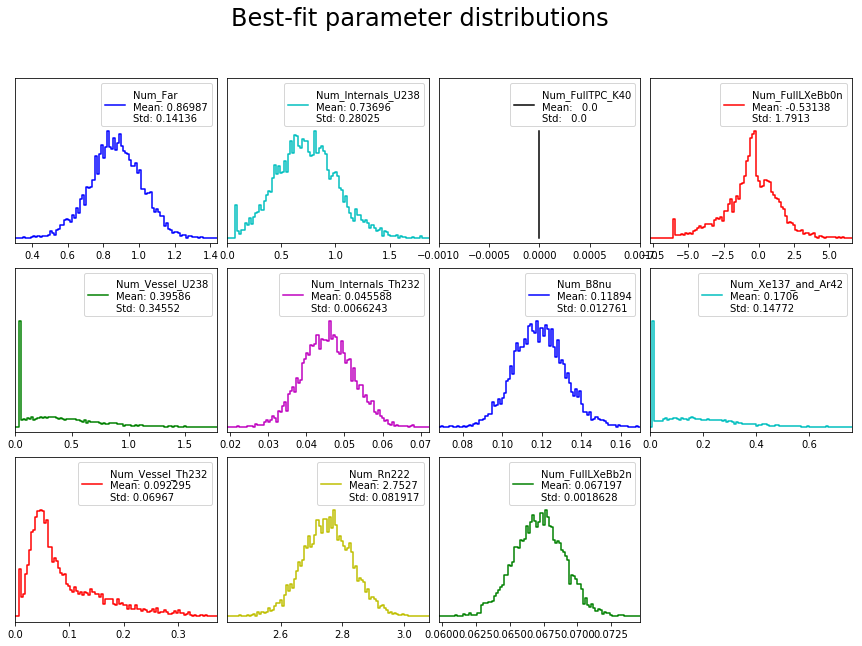

In [113]:
PlotParameterDistributions(parameter_fit_dict,roi_efficiencies=roi_efficiencies)
plt.suptitle('Best-fit parameter distributions',fontsize=24)

plt.savefig('bkg_contribution_fitted_parameter_distributions.png',dpi=200,bbox_inches='tight')



/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0


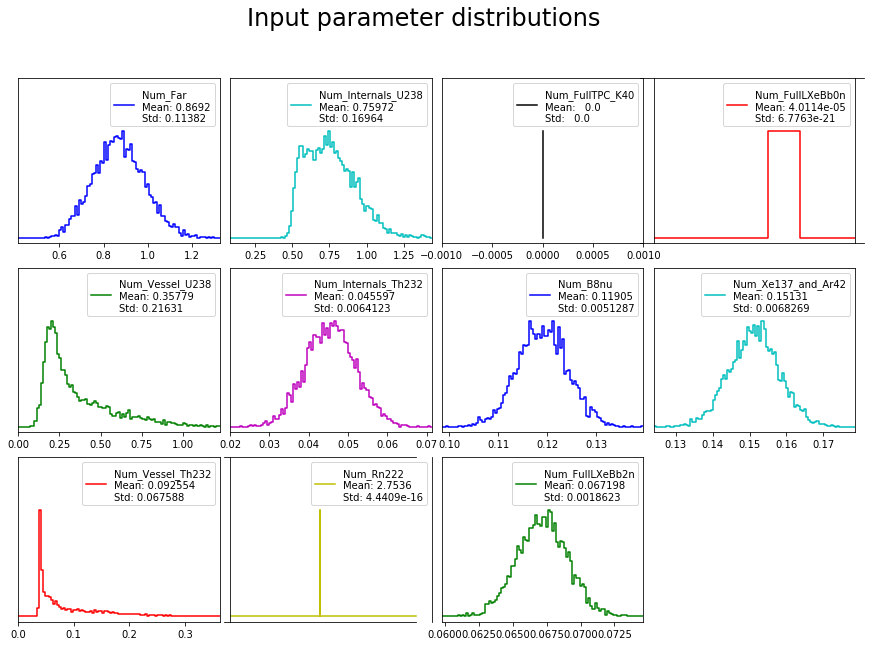

In [114]:
PlotParameterDistributions(parameter_input_dict,roi_efficiencies=roi_efficiencies)
plt.suptitle('Input parameter distributions',fontsize=24)

plt.savefig('bkg_contribution_input_parameter_distributions.png',dpi=200,bbox_inches='tight')



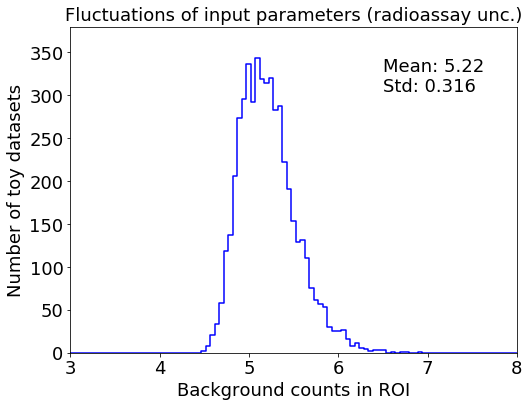

In [115]:
# Compute the mean and error of the summed ROI background

#parameter_sum_fit_array, parameter_sum_input_array 

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

h_input = hl.hist(parameter_sum_input_array, bins=np.linspace(3.,8.,100))
hl.plot1d(h_input)
plt.xlabel('Background counts in ROI')
plt.ylabel('Number of toy datasets')
plt.title('Fluctuations of input parameters (radioassay unc.)',fontsize=18)

plt.gca().text(0.7,0.8,'Mean: {:3.3}\nStd: {:3.3}'.format(\
                                    np.mean(parameter_sum_input_array),\
                                    np.std(parameter_sum_input_array)),\
              transform=plt.gca().transAxes)

plt.xlim(3.,8.)
plt.ylim(0.,380.)

plt.savefig('bkg_level_input_fluctuations.png',dpi=200,bbox_inches='tight')





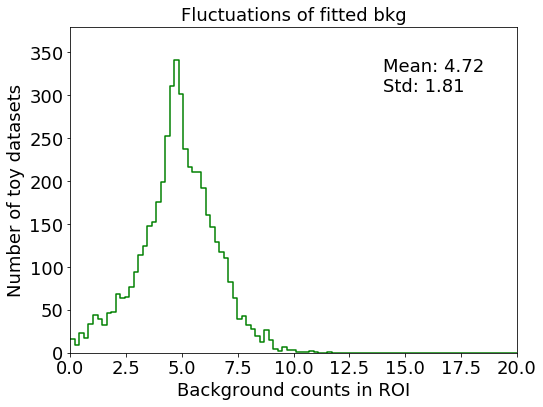

In [116]:
# Compute the mean and error of the summed ROI background

#parameter_sum_fit_array, parameter_sum_input_array 

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

h_input = hl.hist(parameter_sum_fit_array, bins=np.linspace(0.,20.,100))
hl.plot1d(h_input, color='g')
plt.xlabel('Background counts in ROI')
plt.ylabel('Number of toy datasets')
plt.title('Fluctuations of fitted bkg',fontsize=18)

plt.gca().text(0.7,0.8,'Mean: {:3.3}\nStd: {:3.3}'.format(\
                                    np.mean(parameter_sum_fit_array),\
                                    np.std(parameter_sum_fit_array)),\
              transform=plt.gca().transAxes)

plt.xlim(0.,20.)
plt.ylim(0.,380.)

plt.savefig('bkg_level_fit_fluctuations.png',dpi=200,bbox_inches='tight')